# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [ ]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-12-08 20:50:33,724] Making new env: LunarLander-v2


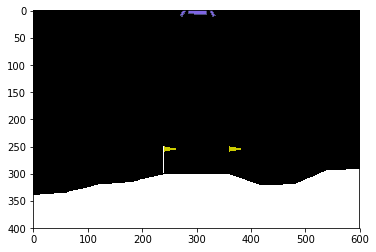

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [5]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu, rectify


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 100, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)
#nn = DenseLayer(nn, 100, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [6]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [7]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [9]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-12-08 20:51:12,578] Making new env: LunarLander-v2


In [10]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 0]]
rewards: [[ 0.2290176  -0.15376662 -0.43129095 -0.6716824   0.        ]]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.08 ms


In [11]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [13]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [14]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [15]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-12-08 20:51:28,935] Making new env: LunarLander-v2
[2017-12-08 20:51:28,939] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:51:28,943] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.0.3429.video000000.mp4
[2017-12-08 20:51:31,673] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 74 timesteps with reward=-260.3938975283751


In [16]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [17]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [18]:
from tqdm import trange

for i in trange(25000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 97/25000 [00:03<14:44, 28.17it/s][2017-12-08 20:51:40,805] Making new env: LunarLander-v2
[2017-12-08 20:51:40,808] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-12-08 20:51:40,994] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  0%|          | 100/25000 [00:03<15:31, 26.74it/s]

Episode finished after 74 timesteps with reward=-182.3353347089688
Episode finished after 93 timesteps with reward=-237.91799562123322
Episode finished after 146 timesteps with reward=-97.38810103335827
iter=100	epsilon=0.910
Current score(mean over 3) = -172.547


  1%|          | 199/25000 [00:07<16:34, 24.95it/s][2017-12-08 20:51:45,311] Making new env: LunarLander-v2
[2017-12-08 20:51:45,313] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:51:45,568] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 67 timesteps with reward=-129.4683515262201
Episode finished after 130 timesteps with reward=-281.8780338316393
Episode finished after 84 timesteps with reward=-198.93086509212148
iter=200	epsilon=0.828
Current score(mean over 3) = -203.426


  1%|          | 298/25000 [00:12<17:50, 23.08it/s][2017-12-08 20:51:50,268] Making new env: LunarLander-v2
[2017-12-08 20:51:50,271] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:51:50,440] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  1%|          | 302/25000 [00:13<18:06, 22.72it/s]

Episode finished after 99 timesteps with reward=-118.43878254666123
Episode finished after 100 timesteps with reward=-362.3816524843204
Episode finished after 74 timesteps with reward=-189.11769429911618
iter=300	epsilon=0.754
Current score(mean over 3) = -223.313


  2%|▏         | 399/25000 [00:18<18:32, 22.11it/s][2017-12-08 20:51:55,340] Making new env: LunarLander-v2
[2017-12-08 20:51:55,343] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:51:55,574] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 135 timesteps with reward=-292.54135850614705
Episode finished after 136 timesteps with reward=-229.27658039592652
Episode finished after 140 timesteps with reward=-256.13980141738057
iter=400	epsilon=0.687
Current score(mean over 3) = -259.319


  2%|▏         | 497/25000 [00:23<19:35, 20.84it/s][2017-12-08 20:52:01,228] Making new env: LunarLander-v2
[2017-12-08 20:52:01,230] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:01,433] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  2%|▏         | 500/25000 [00:24<19:44, 20.68it/s]

Episode finished after 119 timesteps with reward=-422.602849881564
Episode finished after 88 timesteps with reward=-39.43901544212363
Episode finished after 151 timesteps with reward=-341.2962236280064
iter=500	epsilon=0.626
Current score(mean over 3) = -267.779


  2%|▏         | 599/25000 [00:29<19:47, 20.56it/s][2017-12-08 20:52:06,444] Making new env: LunarLander-v2
[2017-12-08 20:52:06,447] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 119 timesteps with reward=-364.30903684378046
Episode finished after 130 timesteps with reward=-244.98801235221552


[2017-12-08 20:52:06,729] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  2%|▏         | 602/25000 [00:29<19:59, 20.34it/s]

Episode finished after 183 timesteps with reward=-521.1568056043973
iter=600	epsilon=0.571
Current score(mean over 3) = -376.818


  3%|▎         | 698/25000 [00:34<20:00, 20.24it/s][2017-12-08 20:52:11,835] Making new env: LunarLander-v2
[2017-12-08 20:52:11,838] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:12,015] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  3%|▎         | 701/25000 [00:34<20:06, 20.14it/s]

Episode finished after 108 timesteps with reward=-168.24830271418526
Episode finished after 109 timesteps with reward=-295.516604558116
Episode finished after 108 timesteps with reward=-216.76480733731688
iter=700	epsilon=0.522
Current score(mean over 3) = -226.843


  3%|▎         | 799/25000 [00:39<20:08, 20.03it/s][2017-12-08 20:52:17,198] Making new env: LunarLander-v2
[2017-12-08 20:52:17,200] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:17,751] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 448 timesteps with reward=-282.0015012408473
Episode finished after 131 timesteps with reward=-210.0065638427463
Episode finished after 178 timesteps with reward=-444.9072116672536
iter=800	epsilon=0.477
Current score(mean over 3) = -312.305


  4%|▎         | 899/25000 [00:45<20:29, 19.60it/s][2017-12-08 20:52:23,272] Making new env: LunarLander-v2
[2017-12-08 20:52:23,275] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:23,510] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 155 timesteps with reward=-383.9475611356298
Episode finished after 92 timesteps with reward=-324.0457088847462
Episode finished after 154 timesteps with reward=-293.8752375303958
iter=900	epsilon=0.436
Current score(mean over 3) = -333.956


  4%|▍         | 999/25000 [00:53<21:23, 18.70it/s][2017-12-08 20:52:30,750] Making new env: LunarLander-v2
[2017-12-08 20:52:30,753] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:31,099] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 186 timesteps with reward=-498.6861637965374
Episode finished after 184 timesteps with reward=-339.2790314682576
Episode finished after 93 timesteps with reward=-208.07999202397946
iter=1000	epsilon=0.399

  4%|▍         | 1099/25000 [01:00<22:04, 18.05it/s][2017-12-08 20:52:38,218] Making new env: LunarLander-v2
[2017-12-08 20:52:38,221] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:52:38,415] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  4%|▍         | 1101/25000 [01:01<22:09, 17.98it/s]


Current score(mean over 3) = -348.682
Episode finished after 79 timesteps with reward=-297.559667361527
Episode finished after 100 timesteps with reward=-267.10495254700777
Episode finished after 103 timesteps with reward=-273.9036209844986
iter=1100	epsilon=0.366
Current score(mean over 3) = -279.523


  5%|▍         | 1199/25000 [01:07<22:29, 17.63it/s][2017-12-08 20:52:45,333] Making new env: LunarLander-v2
[2017-12-08 20:52:45,336] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 171 timesteps with reward=-317.5353811388573


[2017-12-08 20:52:45,758] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  5%|▍         | 1201/25000 [01:08<22:38, 17.52it/s]

Episode finished after 270 timesteps with reward=-536.6198836679994
Episode finished after 96 timesteps with reward=-245.4021650494657
iter=1200	epsilon=0.336
Current score(mean over 3) = -366.519


  5%|▌         | 1299/25000 [01:15<22:58, 17.20it/s][2017-12-08 20:52:52,874] Making new env: LunarLander-v2
[2017-12-08 20:52:52,877] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 203 timesteps with reward=-357.3643100190861


[2017-12-08 20:52:53,409] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  5%|▌         | 1301/25000 [01:16<23:08, 17.07it/s]

Episode finished after 296 timesteps with reward=-997.8646839601582
Episode finished after 137 timesteps with reward=-315.1292109376599
iter=1300	epsilon=0.309
Current score(mean over 3) = -556.786


  6%|▌         | 1399/25000 [01:23<23:31, 16.72it/s][2017-12-08 20:53:01,028] Making new env: LunarLander-v2
[2017-12-08 20:53:01,031] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 82 timesteps with reward=-327.05605510991205


[2017-12-08 20:53:01,603] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 324 timesteps with reward=-1455.6092047320985
Episode finished after 223 timesteps with reward=-861.4739606081109
iter=1400	epsilon=0.284
Current score(mean over 3) = -881.380


  6%|▌         | 1499/25000 [01:32<24:15, 16.15it/s][2017-12-08 20:53:10,162] Making new env: LunarLander-v2
[2017-12-08 20:53:10,165] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 297 timesteps with reward=-425.8115956607696


[2017-12-08 20:53:10,953] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  6%|▌         | 1501/25000 [01:33<24:28, 16.01it/s]

Episode finished after 378 timesteps with reward=-622.013288687512
Episode finished after 146 timesteps with reward=-354.6999249049411
iter=1500	epsilon=0.262
Current score(mean over 3) = -467.508


  6%|▋         | 1598/25000 [01:41<24:51, 15.69it/s][2017-12-08 20:53:19,259] Making new env: LunarLander-v2
[2017-12-08 20:53:19,262] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 222 timesteps with reward=-375.5259628929023
Episode finished after 226 timesteps with reward=-279.8417822833714


[2017-12-08 20:53:19,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  6%|▋         | 1602/25000 [01:42<24:58, 15.61it/s]

Episode finished after 187 timesteps with reward=-398.8208027882572
iter=1600	epsilon=0.242
Current score(mean over 3) = -351.396


  7%|▋         | 1698/25000 [01:50<25:12, 15.40it/s][2017-12-08 20:53:27,674] Making new env: LunarLander-v2
[2017-12-08 20:53:27,678] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:53:28,203] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  7%|▋         | 1700/25000 [01:50<25:20, 15.32it/s]

Episode finished after 375 timesteps with reward=-298.83871426016356
Episode finished after 134 timesteps with reward=-259.23494991238505
Episode finished after 78 timesteps with reward=-348.2710477005699
iter=1700	epsilon=0.224
Current score(mean over 3) = -302.115


  7%|▋         | 1799/25000 [02:02<26:21, 14.67it/s][2017-12-08 20:53:40,005] Making new env: LunarLander-v2
[2017-12-08 20:53:40,008] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 217 timesteps with reward=-302.67352352493697
Episode finished after 339 timesteps with reward=-300.9691872982287


[2017-12-08 20:53:41,045] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  7%|▋         | 1801/25000 [02:03<26:36, 14.53it/s]

Episode finished after 414 timesteps with reward=-324.2044665471485
iter=1800	epsilon=0.207
Current score(mean over 3) = -309.282


  8%|▊         | 1899/25000 [02:16<27:37, 13.94it/s][2017-12-08 20:53:53,626] Making new env: LunarLander-v2
[2017-12-08 20:53:53,629] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 272 timesteps with reward=-289.7517047994424
Episode finished after 412 timesteps with reward=-295.1476717680787


[2017-12-08 20:53:54,710] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  8%|▊         | 1902/25000 [02:17<27:51, 13.82it/s]

Episode finished after 280 timesteps with reward=-509.2438990585997
iter=1900	epsilon=0.192
Current score(mean over 3) = -364.714


  8%|▊         | 1999/25000 [02:29<28:45, 13.33it/s][2017-12-08 20:54:07,345] Making new env: LunarLander-v2
[2017-12-08 20:54:07,348] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 502 timesteps with reward=-456.03519078286416
Episode finished after 85 timesteps with reward=-316.95791218428457


[2017-12-08 20:54:08,568] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  8%|▊         | 2001/25000 [02:31<29:00, 13.21it/s]

Episode finished after 432 timesteps with reward=-265.3287719393377
iter=2000	epsilon=0.179
Current score(mean over 3) = -346.107


  8%|▊         | 2098/25000 [02:42<29:30, 12.93it/s][2017-12-08 20:54:19,656] Making new env: LunarLander-v2
[2017-12-08 20:54:19,658] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 20:54:19,836] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  8%|▊         | 2100/25000 [02:42<29:32, 12.92it/s]

Episode finished after 91 timesteps with reward=-290.54299517007587
Episode finished after 81 timesteps with reward=-309.9347691407462
Episode finished after 95 timesteps with reward=-428.0127977075172
iter=2100	epsilon=0.166
Current score(mean over 3) = -342.830


  9%|▉         | 2198/25000 [02:54<30:08, 12.61it/s][2017-12-08 20:54:31,796] Making new env: LunarLander-v2
[2017-12-08 20:54:31,799] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 243 timesteps with reward=-402.7152285878749
Episode finished after 384 timesteps with reward=-383.2564710000024


[2017-12-08 20:54:32,870] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  9%|▉         | 2202/25000 [02:55<30:20, 12.52it/s]

Episode finished after 402 timesteps with reward=-272.7910869963595
iter=2200	epsilon=0.155
Current score(mean over 3) = -352.921


  9%|▉         | 2299/25000 [03:07<30:49, 12.27it/s][2017-12-08 20:54:44,720] Making new env: LunarLander-v2
[2017-12-08 20:54:44,723] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 163 timesteps with reward=-250.49251513651126
Episode finished after 471 timesteps with reward=-329.31109118844336


[2017-12-08 20:54:46,034] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  9%|▉         | 2301/25000 [03:08<31:03, 12.18it/s]

Episode finished after 514 timesteps with reward=-162.4196927940101
iter=2300	epsilon=0.145
Current score(mean over 3) = -247.408


 10%|▉         | 2398/25000 [03:20<31:33, 11.94it/s][2017-12-08 20:54:58,287] Making new env: LunarLander-v2
[2017-12-08 20:54:58,289] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 81 timesteps with reward=-334.7090875356141


[2017-12-08 20:54:59,680] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 10%|▉         | 2400/25000 [03:22<31:46, 11.86it/s]

Episode finished after 714 timesteps with reward=-375.58598744711514
Episode finished after 243 timesteps with reward=-254.82398369862852
iter=2400	epsilon=0.136
Current score(mean over 3) = -321.706


 10%|▉         | 2499/25000 [03:53<34:59, 10.72it/s][2017-12-08 20:55:30,714] Making new env: LunarLander-v2
[2017-12-08 20:55:30,721] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-266.18621478011426
Episode finished after 1000 timesteps with reward=-170.92365679319707


[2017-12-08 20:55:44,914] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 10%|█         | 2502/25000 [04:07<37:08, 10.10it/s]

Episode finished after 437 timesteps with reward=-329.8849893130799
iter=2500	epsilon=0.128
Current score(mean over 3) = -255.665


 10%|█         | 2598/25000 [04:21<37:34,  9.94it/s][2017-12-08 20:55:58,879] Making new env: LunarLander-v2
[2017-12-08 20:55:58,882] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 557 timesteps with reward=-196.53379209646545
Episode finished after 171 timesteps with reward=-401.21884379613994


[2017-12-08 20:56:00,461] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 10%|█         | 2601/25000 [04:23<37:47,  9.88it/s]

Episode finished after 517 timesteps with reward=-253.67854506768577
iter=2600	epsilon=0.121
Current score(mean over 3) = -283.810


 11%|█         | 2699/25000 [04:37<38:12,  9.73it/s][2017-12-08 20:56:14,950] Making new env: LunarLander-v2
[2017-12-08 20:56:14,953] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 101 timesteps with reward=-339.2667889214656


[2017-12-08 20:56:15,615] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 11%|█         | 2700/25000 [04:38<38:19,  9.70it/s]

Episode finished after 313 timesteps with reward=-376.4033181642546
Episode finished after 171 timesteps with reward=-354.870391204588
iter=2700	epsilon=0.114
Current score(mean over 3) = -356.847


 11%|█         | 2798/25000 [04:51<38:36,  9.59it/s][2017-12-08 20:56:29,318] Making new env: LunarLander-v2
[2017-12-08 20:56:29,321] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 316 timesteps with reward=-251.00475741593613
Episode finished after 317 timesteps with reward=-296.0206427208959


[2017-12-08 20:56:30,761] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 11%|█         | 2802/25000 [04:53<38:46,  9.54it/s]

Episode finished after 596 timesteps with reward=-379.0234406909272
iter=2800	epsilon=0.108
Current score(mean over 3) = -308.683


 12%|█▏        | 2899/25000 [05:05<38:48,  9.49it/s][2017-12-08 20:56:42,849] Making new env: LunarLander-v2
[2017-12-08 20:56:42,852] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 414 timesteps with reward=-267.62022479910866
Episode finished after 160 timesteps with reward=-340.2758015073283


[2017-12-08 20:56:43,792] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 12%|█▏        | 2901/25000 [05:06<38:56,  9.46it/s]

Episode finished after 334 timesteps with reward=-257.1342828303299
iter=2900	epsilon=0.102
Current score(mean over 3) = -288.343


 12%|█▏        | 2999/25000 [05:19<39:01,  9.40it/s][2017-12-08 20:56:56,471] Making new env: LunarLander-v2
[2017-12-08 20:56:56,474] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 185 timesteps with reward=-377.0316638431647
Episode finished after 217 timesteps with reward=-243.90355403387744


[2017-12-08 20:56:57,055] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 12%|█▏        | 3002/25000 [05:19<39:04,  9.38it/s]

Episode finished after 279 timesteps with reward=-236.41414763730472
iter=3000	epsilon=0.097
Current score(mean over 3) = -285.783


 12%|█▏        | 3099/25000 [05:30<38:57,  9.37it/s][2017-12-08 20:57:08,117] Making new env: LunarLander-v2
[2017-12-08 20:57:08,119] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 320 timesteps with reward=-411.762937259306
Episode finished after 183 timesteps with reward=-182.15238007136014


[2017-12-08 20:57:08,909] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 12%|█▏        | 3102/25000 [05:31<39:02,  9.35it/s]

Episode finished after 280 timesteps with reward=-192.68037670655428
iter=3100	epsilon=0.093
Current score(mean over 3) = -262.199


 13%|█▎        | 3198/25000 [05:43<39:01,  9.31it/s][2017-12-08 20:57:20,912] Making new env: LunarLander-v2
[2017-12-08 20:57:20,915] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 210 timesteps with reward=-395.0758325690358


[2017-12-08 20:57:21,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 13%|█▎        | 3200/25000 [05:44<39:05,  9.30it/s]

Episode finished after 170 timesteps with reward=-195.2337117106228
Episode finished after 197 timesteps with reward=-92.52183249035782
iter=3200	epsilon=0.089
Current score(mean over 3) = -227.610


 13%|█▎        | 3298/25000 [05:55<38:56,  9.29it/s][2017-12-08 20:57:32,495] Making new env: LunarLander-v2
[2017-12-08 20:57:32,498] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 314 timesteps with reward=-389.24710659697445
Episode finished after 199 timesteps with reward=-356.4918240377052


[2017-12-08 20:57:33,244] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 13%|█▎        | 3302/25000 [05:56<39:00,  9.27it/s]

Episode finished after 253 timesteps with reward=-402.99762883773485
iter=3300	epsilon=0.085
Current score(mean over 3) = -382.912


 14%|█▎        | 3399/25000 [06:05<38:42,  9.30it/s][2017-12-08 20:57:42,799] Making new env: LunarLander-v2
[2017-12-08 20:57:42,801] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 165 timesteps with reward=-423.0481853939984
Episode finished after 208 timesteps with reward=-427.0495483059345


[2017-12-08 20:57:43,322] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▎        | 3401/25000 [06:06<38:45,  9.29it/s]

Episode finished after 221 timesteps with reward=-314.18378635486874
iter=3400	epsilon=0.082
Current score(mean over 3) = -388.094


 14%|█▍        | 3499/25000 [06:16<38:31,  9.30it/s][2017-12-08 20:57:53,489] Making new env: LunarLander-v2
[2017-12-08 20:57:53,492] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 172 timesteps with reward=-499.79362244488357
Episode finished after 209 timesteps with reward=-545.3486753755527


[2017-12-08 20:57:54,278] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▍        | 3501/25000 [06:17<38:36,  9.28it/s]

Episode finished after 180 timesteps with reward=-267.94367061595636
iter=3500	epsilon=0.079
Current score(mean over 3) = -437.695


 14%|█▍        | 3599/25000 [06:29<38:37,  9.23it/s][2017-12-08 20:58:07,179] Making new env: LunarLander-v2
[2017-12-08 20:58:07,182] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 76 timesteps with reward=-602.4820852318362


[2017-12-08 20:58:07,701] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▍        | 3600/25000 [06:30<38:40,  9.22it/s]

Episode finished after 165 timesteps with reward=-289.36162646375647
Episode finished after 171 timesteps with reward=-310.92189856484265
iter=3600	epsilon=0.076
Current score(mean over 3) = -400.922


 15%|█▍        | 3699/25000 [06:44<38:48,  9.15it/s][2017-12-08 20:58:21,642] Making new env: LunarLander-v2
[2017-12-08 20:58:21,645] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 150 timesteps with reward=-321.17653155002364
Episode finished after 98 timesteps with reward=-499.93006553457843


[2017-12-08 20:58:22,116] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 15%|█▍        | 3701/25000 [06:44<38:50,  9.14it/s]

Episode finished after 147 timesteps with reward=-366.3760277367691
iter=3700	epsilon=0.073
Current score(mean over 3) = -395.828


 15%|█▌        | 3799/25000 [07:00<39:06,  9.03it/s][2017-12-08 20:58:37,947] Making new env: LunarLander-v2
[2017-12-08 20:58:37,951] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 171 timesteps with reward=-198.64383185039134


[2017-12-08 20:58:38,663] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 15%|█▌        | 3800/25000 [07:01<39:11,  9.02it/s]

Episode finished after 208 timesteps with reward=-351.462109512731
Episode finished after 152 timesteps with reward=-309.034558062846
iter=3800	epsilon=0.071
Current score(mean over 3) = -286.380


 16%|█▌        | 3899/25000 [07:14<39:11,  8.97it/s][2017-12-08 20:58:51,990] Making new env: LunarLander-v2
[2017-12-08 20:58:51,993] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 232 timesteps with reward=-358.00752743763553


[2017-12-08 20:58:52,710] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 16%|█▌        | 3900/25000 [07:15<39:15,  8.96it/s]

Episode finished after 179 timesteps with reward=-188.2018841566977
Episode finished after 122 timesteps with reward=-147.33432958011764
iter=3900	epsilon=0.069
Current score(mean over 3) = -231.181


 16%|█▌        | 3999/25000 [07:29<39:19,  8.90it/s][2017-12-08 20:59:06,697] Making new env: LunarLander-v2
[2017-12-08 20:59:06,700] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 152 timesteps with reward=-332.8571230334804
Episode finished after 215 timesteps with reward=-357.53413668161625


[2017-12-08 20:59:07,429] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 16%|█▌        | 4001/25000 [07:30<39:23,  8.89it/s]

Episode finished after 193 timesteps with reward=-162.41237419794132
iter=4000	epsilon=0.067
Current score(mean over 3) = -284.268


 16%|█▋        | 4099/25000 [07:43<39:23,  8.84it/s][2017-12-08 20:59:20,907] Making new env: LunarLander-v2
[2017-12-08 20:59:20,910] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 139 timesteps with reward=-263.1006353200183
Episode finished after 188 timesteps with reward=-301.5000475779184


[2017-12-08 20:59:21,846] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 16%|█▋        | 4101/25000 [07:44<39:28,  8.82it/s]

Episode finished after 320 timesteps with reward=-356.7224620955086
iter=4100	epsilon=0.066
Current score(mean over 3) = -307.108


 17%|█▋        | 4199/25000 [07:57<39:27,  8.79it/s][2017-12-08 20:59:35,278] Making new env: LunarLander-v2
[2017-12-08 20:59:35,281] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 203 timesteps with reward=-261.8367755638379
Episode finished after 151 timesteps with reward=-286.55891543617787


[2017-12-08 20:59:36,295] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 17%|█▋        | 4200/25000 [07:59<39:32,  8.77it/s]

Episode finished after 330 timesteps with reward=-415.2214387463471
iter=4200	epsilon=0.064
Current score(mean over 3) = -321.206


 17%|█▋        | 4299/25000 [08:14<39:39,  8.70it/s][2017-12-08 20:59:51,533] Making new env: LunarLander-v2
[2017-12-08 20:59:51,536] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 345 timesteps with reward=-112.60119013147003
Episode finished after 299 timesteps with reward=-219.69794223791962


[2017-12-08 20:59:53,371] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 17%|█▋        | 4301/25000 [08:16<39:48,  8.67it/s]

Episode finished after 380 timesteps with reward=-84.3882274598644
iter=4300	epsilon=0.063
Current score(mean over 3) = -138.896


 18%|█▊        | 4399/25000 [08:30<39:51,  8.61it/s][2017-12-08 21:00:08,066] Making new env: LunarLander-v2
[2017-12-08 21:00:08,069] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 296 timesteps with reward=-169.46556971686806
Episode finished after 273 timesteps with reward=-279.7911323030204


[2017-12-08 21:00:09,196] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 18%|█▊        | 4401/25000 [08:32<39:56,  8.59it/s]

Episode finished after 175 timesteps with reward=-38.80958296222738
iter=4400	epsilon=0.062
Current score(mean over 3) = -162.689


 18%|█▊        | 4499/25000 [08:47<40:03,  8.53it/s][2017-12-08 21:00:24,939] Making new env: LunarLander-v2
[2017-12-08 21:00:24,942] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 292 timesteps with reward=-152.67050815526778
Episode finished after 410 timesteps with reward=-339.7980285865748


[2017-12-08 21:00:26,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 18%|█▊        | 4501/25000 [08:49<40:12,  8.50it/s]

Episode finished after 356 timesteps with reward=-423.25583007660964
iter=4500	epsilon=0.061
Current score(mean over 3) = -305.241


 18%|█▊        | 4599/25000 [09:05<40:17,  8.44it/s][2017-12-08 21:00:42,447] Making new env: LunarLander-v2
[2017-12-08 21:00:42,450] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 147 timesteps with reward=-237.5874497077171
Episode finished after 256 timesteps with reward=-281.3160063365409


[2017-12-08 21:00:43,630] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 18%|█▊        | 4601/25000 [09:06<40:23,  8.42it/s]

Episode finished after 321 timesteps with reward=-155.41091729551286
iter=4600	epsilon=0.060
Current score(mean over 3) = -224.771


 19%|█▉        | 4699/25000 [09:21<40:23,  8.38it/s][2017-12-08 21:00:58,482] Making new env: LunarLander-v2
[2017-12-08 21:00:58,484] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 232 timesteps with reward=-323.345827792403


[2017-12-08 21:00:59,347] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 19%|█▉        | 4700/25000 [09:22<40:27,  8.36it/s]

Episode finished after 244 timesteps with reward=-129.06989712469345
Episode finished after 152 timesteps with reward=-186.43054119625907
iter=4700	epsilon=0.059
Current score(mean over 3) = -212.949


 19%|█▉        | 4799/25000 [09:36<40:28,  8.32it/s][2017-12-08 21:01:14,349] Making new env: LunarLander-v2
[2017-12-08 21:01:14,352] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 425 timesteps with reward=-280.66408612882094
Episode finished after 231 timesteps with reward=-189.4696059091841


[2017-12-08 21:01:15,950] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 19%|█▉        | 4801/25000 [09:38<40:35,  8.29it/s]

Episode finished after 344 timesteps with reward=-389.8220340256558
iter=4800	epsilon=0.058
Current score(mean over 3) = -286.652


 20%|█▉        | 4899/25000 [09:52<40:32,  8.26it/s][2017-12-08 21:01:30,310] Making new env: LunarLander-v2
[2017-12-08 21:01:30,313] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 241 timesteps with reward=-272.0764132225503
Episode finished after 194 timesteps with reward=-299.54995786674056


[2017-12-08 21:01:31,467] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 20%|█▉        | 4901/25000 [09:54<40:37,  8.25it/s]

Episode finished after 362 timesteps with reward=-266.4767417070363
iter=4900	epsilon=0.057
Current score(mean over 3) = -279.368


 20%|█▉        | 4999/25000 [10:10<40:43,  8.19it/s][2017-12-08 21:01:48,159] Making new env: LunarLander-v2
[2017-12-08 21:01:48,162] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 311 timesteps with reward=-266.9446077470675
Episode finished after 174 timesteps with reward=-84.0809524109807


[2017-12-08 21:01:49,326] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 20%|██        | 5001/25000 [10:12<40:48,  8.17it/s]

Episode finished after 304 timesteps with reward=-352.1442931759879
iter=5000	epsilon=0.056
Current score(mean over 3) = -234.390


 20%|██        | 5099/25000 [10:26<40:43,  8.14it/s][2017-12-08 21:02:03,530] Making new env: LunarLander-v2
[2017-12-08 21:02:03,533] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 331 timesteps with reward=-131.9750733291404
Episode finished after 153 timesteps with reward=-133.20378132373466


[2017-12-08 21:02:04,781] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 20%|██        | 5101/25000 [10:27<40:48,  8.13it/s]

Episode finished after 309 timesteps with reward=-200.48524368817715
iter=5100	epsilon=0.056
Current score(mean over 3) = -155.221


 21%|██        | 5199/25000 [10:42<40:45,  8.10it/s][2017-12-08 21:02:19,403] Making new env: LunarLander-v2
[2017-12-08 21:02:19,405] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 319 timesteps with reward=-315.88138035490744
Episode finished after 210 timesteps with reward=-234.44099326904245


[2017-12-08 21:02:20,480] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 21%|██        | 5201/25000 [10:43<40:49,  8.08it/s]

Episode finished after 239 timesteps with reward=-265.89275693808924
iter=5200	epsilon=0.055
Current score(mean over 3) = -272.072


 21%|██        | 5299/25000 [10:56<40:41,  8.07it/s][2017-12-08 21:02:34,034] Making new env: LunarLander-v2
[2017-12-08 21:02:34,037] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 236 timesteps with reward=-286.4086980747562
Episode finished after 167 timesteps with reward=-236.22192203781185


[2017-12-08 21:02:34,853] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 21%|██        | 5301/25000 [10:57<40:44,  8.06it/s]

Episode finished after 200 timesteps with reward=-246.17025690759718
iter=5300	epsilon=0.055
Current score(mean over 3) = -256.267


 22%|██▏       | 5399/25000 [11:11<40:38,  8.04it/s][2017-12-08 21:02:48,929] Making new env: LunarLander-v2
[2017-12-08 21:02:48,932] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 141 timesteps with reward=-358.60555585180145
Episode finished after 128 timesteps with reward=-343.3256447502115


[2017-12-08 21:02:49,512] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 22%|██▏       | 5401/25000 [11:12<40:39,  8.03it/s]

Episode finished after 207 timesteps with reward=-119.58558559966664
iter=5400	epsilon=0.054
Current score(mean over 3) = -273.839


 22%|██▏       | 5499/25000 [11:25<40:30,  8.02it/s][2017-12-08 21:03:02,836] Making new env: LunarLander-v2
[2017-12-08 21:03:02,839] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 144 timesteps with reward=-431.82623176370487
Episode finished after 137 timesteps with reward=-14.948802620594122


[2017-12-08 21:03:03,452] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 22%|██▏       | 5501/25000 [11:26<40:32,  8.02it/s]

Episode finished after 198 timesteps with reward=-374.3784935585172
iter=5500	epsilon=0.054
Current score(mean over 3) = -273.718


 22%|██▏       | 5599/25000 [11:39<40:22,  8.01it/s][2017-12-08 21:03:16,500] Making new env: LunarLander-v2
[2017-12-08 21:03:16,503] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 154 timesteps with reward=-251.1718335638691


[2017-12-08 21:03:17,019] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 22%|██▏       | 5600/25000 [11:39<40:24,  8.00it/s]

Episode finished after 169 timesteps with reward=-383.87252954053645
Episode finished after 100 timesteps with reward=-179.98718167343253
iter=5600	epsilon=0.054
Current score(mean over 3) = -271.677


 23%|██▎       | 5699/25000 [11:52<40:13,  8.00it/s][2017-12-08 21:03:29,877] Making new env: LunarLander-v2
[2017-12-08 21:03:29,879] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 107 timesteps with reward=-248.87995007227536
Episode finished after 149 timesteps with reward=-294.4373932707381


[2017-12-08 21:03:30,336] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 23%|██▎       | 5701/25000 [11:53<40:14,  7.99it/s]

Episode finished after 130 timesteps with reward=-237.7955849131498
iter=5700	epsilon=0.053
Current score(mean over 3) = -260.371


 23%|██▎       | 5799/25000 [12:05<40:01,  7.99it/s][2017-12-08 21:03:42,760] Making new env: LunarLander-v2
[2017-12-08 21:03:42,762] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 93 timesteps with reward=-353.5272755963608
Episode finished after 117 timesteps with reward=-580.9367949069986


[2017-12-08 21:03:43,094] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 23%|██▎       | 5801/25000 [12:05<40:02,  7.99it/s]

Episode finished after 90 timesteps with reward=-564.4480094268711
iter=5800	epsilon=0.053
Current score(mean over 3) = -499.637


 24%|██▎       | 5899/25000 [12:18<39:50,  7.99it/s][2017-12-08 21:03:55,479] Making new env: LunarLander-v2
[2017-12-08 21:03:55,481] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 21:03:55,852] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▎       | 5900/25000 [12:18<39:51,  7.99it/s]

Episode finished after 139 timesteps with reward=-557.2523033904886
Episode finished after 89 timesteps with reward=-769.4487204792105
Episode finished after 108 timesteps with reward=-163.92362664237868
iter=5900	epsilon=0.053
Current score(mean over 3) = -496.875


 24%|██▍       | 5999/25000 [12:30<39:38,  7.99it/s][2017-12-08 21:04:08,245] Making new env: LunarLander-v2
[2017-12-08 21:04:08,248] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 90 timesteps with reward=-510.8911465493384
Episode finished after 133 timesteps with reward=-368.7890260737745


[2017-12-08 21:04:08,588] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▍       | 6001/25000 [12:31<39:39,  7.99it/s]

Episode finished after 101 timesteps with reward=-607.9078672121502
iter=6000	epsilon=0.052
Current score(mean over 3) = -495.863


 24%|██▍       | 6099/25000 [12:43<39:26,  7.99it/s][2017-12-08 21:04:20,935] Making new env: LunarLander-v2
[2017-12-08 21:04:20,938] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 81 timesteps with reward=-630.7537845707543
Episode finished after 99 timesteps with reward=-161.99815456614462


[2017-12-08 21:04:21,420] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▍       | 6101/25000 [12:44<39:27,  7.98it/s]

Episode finished after 224 timesteps with reward=-68.51854594523375
iter=6100	epsilon=0.052
Current score(mean over 3) = -287.090


 25%|██▍       | 6199/25000 [12:56<39:14,  7.98it/s][2017-12-08 21:04:33,831] Making new env: LunarLander-v2
[2017-12-08 21:04:33,834] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-08 21:04:34,130] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 25%|██▍       | 6200/25000 [12:56<39:15,  7.98it/s]

Episode finished after 114 timesteps with reward=-202.4215291968991
Episode finished after 88 timesteps with reward=-518.0476131191419
Episode finished after 95 timesteps with reward=-97.88708285391954
iter=6200	epsilon=0.052
Current score(mean over 3) = -272.785


 25%|██▌       | 6299/25000 [13:09<39:03,  7.98it/s][2017-12-08 21:04:46,731] Making new env: LunarLander-v2
[2017-12-08 21:04:46,734] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 177 timesteps with reward=-255.0092334222695
Episode finished after 138 timesteps with reward=-244.4461394019114


[2017-12-08 21:04:47,358] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 25%|██▌       | 6301/25000 [13:10<39:05,  7.97it/s]

Episode finished after 183 timesteps with reward=-327.18299804406536
iter=6300	epsilon=0.052
Current score(mean over 3) = -275.546


 26%|██▌       | 6399/25000 [13:23<38:54,  7.97it/s][2017-12-08 21:05:00,416] Making new env: LunarLander-v2
[2017-12-08 21:05:00,419] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 236 timesteps with reward=-17.309790669359387
Episode finished after 269 timesteps with reward=-423.097627153078


[2017-12-08 21:05:01,622] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 26%|██▌       | 6401/25000 [13:24<38:57,  7.96it/s]

Episode finished after 292 timesteps with reward=-308.2425780993341
iter=6400	epsilon=0.052
Current score(mean over 3) = -249.550


 26%|██▌       | 6499/25000 [13:37<38:47,  7.95it/s][2017-12-08 21:05:14,940] Making new env: LunarLander-v2
[2017-12-08 21:05:14,943] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 132 timesteps with reward=-205.59650540362242
Episode finished after 255 timesteps with reward=-242.26302791474993


[2017-12-08 21:05:16,422] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 26%|██▌       | 6501/25000 [13:39<38:51,  7.93it/s]

Episode finished after 511 timesteps with reward=-74.99518500099263
iter=6500	epsilon=0.051
Current score(mean over 3) = -174.285


 26%|██▋       | 6599/25000 [13:55<38:48,  7.90it/s][2017-12-08 21:05:32,545] Making new env: LunarLander-v2
[2017-12-08 21:05:32,548] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 418 timesteps with reward=-154.47658202164888
Episode finished after 238 timesteps with reward=-125.18702669082867


[2017-12-08 21:05:34,544] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 26%|██▋       | 6601/25000 [13:57<38:54,  7.88it/s]

Episode finished after 309 timesteps with reward=-130.90616730057837
iter=6600	epsilon=0.051
Current score(mean over 3) = -136.857


 27%|██▋       | 6699/25000 [14:17<39:02,  7.81it/s][2017-12-08 21:05:54,933] Making new env: LunarLander-v2
[2017-12-08 21:05:54,936] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-112.61255854638037


[2017-12-08 21:05:59,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 27%|██▋       | 6700/25000 [14:22<39:15,  7.77it/s]

Episode finished after 221 timesteps with reward=-93.29274025257838
Episode finished after 149 timesteps with reward=-191.52835564648782
iter=6700	epsilon=0.051
Current score(mean over 3) = -132.478


 27%|██▋       | 6799/25000 [14:39<39:14,  7.73it/s][2017-12-08 21:06:17,041] Making new env: LunarLander-v2
[2017-12-08 21:06:17,045] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 338 timesteps with reward=-186.88665996492898
Episode finished after 188 timesteps with reward=-18.082677898639133


[2017-12-08 21:06:18,077] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 27%|██▋       | 6801/25000 [14:40<39:17,  7.72it/s]

Episode finished after 199 timesteps with reward=-93.82753859576063
iter=6800	epsilon=0.051
Current score(mean over 3) = -99.599


 28%|██▊       | 6899/25000 [14:55<39:10,  7.70it/s][2017-12-08 21:06:33,377] Making new env: LunarLander-v2
[2017-12-08 21:06:33,380] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 292 timesteps with reward=-112.08251737390736
Episode finished after 113 timesteps with reward=-50.21418546888031


[2017-12-08 21:06:35,780] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 28%|██▊       | 6900/25000 [14:58<39:17,  7.68it/s]

Episode finished after 698 timesteps with reward=-137.15447382755227
iter=6900	epsilon=0.051
Current score(mean over 3) = -99.817


 28%|██▊       | 6999/25000 [15:15<39:15,  7.64it/s][2017-12-08 21:06:53,143] Making new env: LunarLander-v2
[2017-12-08 21:06:53,146] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 112 timesteps with reward=-207.9059842101497
Episode finished after 419 timesteps with reward=-30.981951850357476


[2017-12-08 21:06:54,310] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 28%|██▊       | 7000/25000 [15:17<39:18,  7.63it/s]

Episode finished after 257 timesteps with reward=-263.87530673842053
iter=7000	epsilon=0.051
Current score(mean over 3) = -167.588


 28%|██▊       | 7099/25000 [15:37<39:24,  7.57it/s][2017-12-08 21:07:15,369] Making new env: LunarLander-v2
[2017-12-08 21:07:15,373] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 427 timesteps with reward=-152.52273476603204
Episode finished after 431 timesteps with reward=-194.1651124186859


[2017-12-08 21:07:17,305] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 28%|██▊       | 7101/25000 [15:40<39:29,  7.55it/s]

Episode finished after 225 timesteps with reward=-86.61607254993419
iter=7100	epsilon=0.051
Current score(mean over 3) = -144.435


 29%|██▉       | 7199/25000 [16:00<39:34,  7.50it/s][2017-12-08 21:07:37,769] Making new env: LunarLander-v2
[2017-12-08 21:07:37,772] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 523 timesteps with reward=-178.44451758849783
Episode finished after 601 timesteps with reward=-265.24794946473764


[2017-12-08 21:07:42,791] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 29%|██▉       | 7200/25000 [16:05<39:47,  7.46it/s]

Episode finished after 794 timesteps with reward=-305.3488621105125
iter=7200	epsilon=0.051
Current score(mean over 3) = -249.680


 29%|██▉       | 7299/25000 [16:24<39:47,  7.41it/s][2017-12-08 21:08:01,882] Making new env: LunarLander-v2
[2017-12-08 21:08:01,885] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 250 timesteps with reward=-29.815744058889734
Episode finished after 974 timesteps with reward=-353.55723213195785


[2017-12-08 21:08:06,979] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 29%|██▉       | 7301/25000 [16:29<39:59,  7.38it/s]

Episode finished after 757 timesteps with reward=-298.4078409236894
iter=7300	epsilon=0.051
Current score(mean over 3) = -227.260


 30%|██▉       | 7399/25000 [16:47<39:56,  7.34it/s][2017-12-08 21:08:24,815] Making new env: LunarLander-v2
[2017-12-08 21:08:24,818] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 273 timesteps with reward=-161.76165740077244
Episode finished after 898 timesteps with reward=-352.37622386427324


[2017-12-08 21:08:28,763] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|██▉       | 7401/25000 [16:51<40:05,  7.32it/s]

Episode finished after 290 timesteps with reward=-119.71321847900009
iter=7400	epsilon=0.051
Current score(mean over 3) = -211.284


 30%|██▉       | 7499/25000 [17:11<40:06,  7.27it/s][2017-12-08 21:08:48,804] Making new env: LunarLander-v2
[2017-12-08 21:08:48,807] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 904 timesteps with reward=-291.38158563169526
Episode finished after 523 timesteps with reward=-212.69192916348734


[2017-12-08 21:08:54,800] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|███       | 7501/25000 [17:17<40:20,  7.23it/s]

Episode finished after 557 timesteps with reward=-357.2965014831972
iter=7500	epsilon=0.051
Current score(mean over 3) = -287.123


 30%|███       | 7599/25000 [17:37<40:21,  7.19it/s][2017-12-08 21:09:14,792] Making new env: LunarLander-v2
[2017-12-08 21:09:14,795] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 362 timesteps with reward=-212.71858412357412
Episode finished after 706 timesteps with reward=-298.7881061518278


[2017-12-08 21:09:21,429] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|███       | 7600/25000 [17:44<40:36,  7.14it/s]

Episode finished after 1000 timesteps with reward=-249.95778531075135
iter=7600	epsilon=0.050
Current score(mean over 3) = -253.821


 31%|███       | 7699/25000 [18:02<40:32,  7.11it/s][2017-12-08 21:09:39,983] Making new env: LunarLander-v2
[2017-12-08 21:09:39,986] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 312 timesteps with reward=-158.7347368024813
Episode finished after 592 timesteps with reward=-241.0959367538463


[2017-12-08 21:09:42,561] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 31%|███       | 7701/25000 [18:05<40:38,  7.09it/s]

Episode finished after 422 timesteps with reward=-192.52010731313214
iter=7700	epsilon=0.050
Current score(mean over 3) = -197.450


 31%|███       | 7799/25000 [18:23<40:32,  7.07it/s][2017-12-08 21:10:00,509] Making new env: LunarLander-v2
[2017-12-08 21:10:00,512] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 168 timesteps with reward=-149.67760903054068
Episode finished after 654 timesteps with reward=-313.34925730810835


[2017-12-08 21:10:02,999] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 31%|███       | 7801/25000 [18:25<40:38,  7.05it/s]

Episode finished after 448 timesteps with reward=-262.8459682707322
iter=7800	epsilon=0.050
Current score(mean over 3) = -241.958


 32%|███▏      | 7899/25000 [18:42<40:30,  7.04it/s][2017-12-08 21:10:20,048] Making new env: LunarLander-v2
[2017-12-08 21:10:20,052] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 514 timesteps with reward=-193.38635140889215
Episode finished after 773 timesteps with reward=-288.5072736354906


[2017-12-08 21:10:24,655] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 32%|███▏      | 7901/25000 [18:47<40:40,  7.01it/s]

Episode finished after 581 timesteps with reward=-238.65543760072512
iter=7900	epsilon=0.050
Current score(mean over 3) = -240.183


 32%|███▏      | 7999/25000 [19:06<40:36,  6.98it/s][2017-12-08 21:10:43,938] Making new env: LunarLander-v2
[2017-12-08 21:10:43,941] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 435 timesteps with reward=-215.1673466003904
Episode finished after 279 timesteps with reward=-171.94913532594853


[2017-12-08 21:10:47,172] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 32%|███▏      | 8000/25000 [19:09<40:43,  6.96it/s]

Episode finished after 575 timesteps with reward=-194.27106436855019
iter=8000	epsilon=0.050
Current score(mean over 3) = -193.796


 32%|███▏      | 8099/25000 [19:31<40:44,  6.92it/s][2017-12-08 21:11:08,632] Making new env: LunarLander-v2
[2017-12-08 21:11:08,636] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 288 timesteps with reward=-137.080925633141
Episode finished after 217 timesteps with reward=-150.00820552361148


[2017-12-08 21:11:11,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 32%|███▏      | 8101/25000 [19:34<40:49,  6.90it/s]

Episode finished after 652 timesteps with reward=-220.67726436251695
iter=8100	epsilon=0.050
Current score(mean over 3) = -169.255


 33%|███▎      | 8199/25000 [19:53<40:46,  6.87it/s][2017-12-08 21:11:31,283] Making new env: LunarLander-v2
[2017-12-08 21:11:31,286] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 493 timesteps with reward=-193.39422316451567
Episode finished after 350 timesteps with reward=-153.58184465988148


[2017-12-08 21:11:34,962] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 33%|███▎      | 8201/25000 [19:57<40:53,  6.85it/s]

Episode finished after 816 timesteps with reward=-223.2258726292734
iter=8200	epsilon=0.050
Current score(mean over 3) = -190.067


 33%|███▎      | 8299/25000 [20:17<40:49,  6.82it/s][2017-12-08 21:11:54,740] Making new env: LunarLander-v2
[2017-12-08 21:11:54,743] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 786 timesteps with reward=-248.52621164539988


[2017-12-08 21:11:57,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 33%|███▎      | 8300/25000 [20:20<40:55,  6.80it/s]

Episode finished after 384 timesteps with reward=-173.21545815870962
Episode finished after 126 timesteps with reward=-3.6351012684396267
iter=8300	epsilon=0.050
Current score(mean over 3) = -141.792


 34%|███▎      | 8399/25000 [20:43<40:58,  6.75it/s][2017-12-08 21:12:21,182] Making new env: LunarLander-v2
[2017-12-08 21:12:21,185] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 249 timesteps with reward=-190.6516232090582
Episode finished after 261 timesteps with reward=-182.04481597031116


[2017-12-08 21:12:23,502] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▎      | 8400/25000 [20:46<41:02,  6.74it/s]

Episode finished after 480 timesteps with reward=-149.8267264883523
iter=8400	epsilon=0.050
Current score(mean over 3) = -174.174


 34%|███▍      | 8499/25000 [21:05<40:57,  6.72it/s][2017-12-08 21:12:43,092] Making new env: LunarLander-v2
[2017-12-08 21:12:43,094] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 729 timesteps with reward=-227.4765149833466
Episode finished after 339 timesteps with reward=-77.14100436298995


[2017-12-08 21:12:46,542] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▍      | 8501/25000 [21:09<41:03,  6.70it/s]

Episode finished after 301 timesteps with reward=-132.67434395828903
iter=8500	epsilon=0.050
Current score(mean over 3) = -145.764


 34%|███▍      | 8599/25000 [21:27<40:55,  6.68it/s][2017-12-08 21:13:04,570] Making new env: LunarLander-v2
[2017-12-08 21:13:04,572] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 296 timesteps with reward=-178.92977785539222
Episode finished after 296 timesteps with reward=-166.24995396619545


[2017-12-08 21:13:07,887] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▍      | 8601/25000 [21:30<41:01,  6.66it/s]

Episode finished after 810 timesteps with reward=82.27963665170586
iter=8600	epsilon=0.050
Current score(mean over 3) = -87.633


 35%|███▍      | 8699/25000 [21:47<40:49,  6.66it/s][2017-12-08 21:13:24,461] Making new env: LunarLander-v2
[2017-12-08 21:13:24,464] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 556 timesteps with reward=115.62138994111386
Episode finished after 640 timesteps with reward=-203.9632953362148


[2017-12-08 21:13:27,794] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 35%|███▍      | 8701/25000 [21:50<40:55,  6.64it/s]

Episode finished after 195 timesteps with reward=-102.93536891836534
iter=8700	epsilon=0.050
Current score(mean over 3) = -63.759


 35%|███▌      | 8799/25000 [22:10<40:49,  6.61it/s][2017-12-08 21:13:47,623] Making new env: LunarLander-v2
[2017-12-08 21:13:47,626] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 269 timesteps with reward=-135.36627419458006
Episode finished after 558 timesteps with reward=-170.89023165591854


[2017-12-08 21:13:50,046] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 35%|███▌      | 8800/25000 [22:12<40:53,  6.60it/s]

Episode finished after 363 timesteps with reward=-144.28783458043168
iter=8800	epsilon=0.050
Current score(mean over 3) = -150.181


 36%|███▌      | 8899/25000 [22:34<40:50,  6.57it/s][2017-12-08 21:14:11,801] Making new env: LunarLander-v2
[2017-12-08 21:14:11,805] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 331 timesteps with reward=-78.99589499539444
Episode finished after 313 timesteps with reward=-149.24595144335373


[2017-12-08 21:14:15,569] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 36%|███▌      | 8901/25000 [22:38<40:57,  6.55it/s]

Episode finished after 1000 timesteps with reward=-142.20988368203433
iter=8900	epsilon=0.050
Current score(mean over 3) = -123.484


 36%|███▌      | 8999/25000 [22:55<40:46,  6.54it/s][2017-12-08 21:14:33,504] Making new env: LunarLander-v2
[2017-12-08 21:14:33,509] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 396 timesteps with reward=-126.97579036742783
Episode finished after 722 timesteps with reward=-210.77528745862196


[2017-12-08 21:14:36,503] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 36%|███▌      | 9000/25000 [22:59<40:51,  6.53it/s]

Episode finished after 272 timesteps with reward=-63.17173705665728
iter=9000	epsilon=0.050
Current score(mean over 3) = -133.641


 36%|███▋      | 9099/25000 [23:18<40:43,  6.51it/s][2017-12-08 21:14:55,917] Making new env: LunarLander-v2
[2017-12-08 21:14:55,920] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 834 timesteps with reward=-231.5812863915167
Episode finished after 501 timesteps with reward=124.68829076889358


[2017-12-08 21:15:00,750] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 36%|███▋      | 9100/25000 [23:23<40:52,  6.48it/s]

Episode finished after 500 timesteps with reward=-136.91942123160993
iter=9100	epsilon=0.050
Current score(mean over 3) = -81.271


 37%|███▋      | 9199/25000 [23:44<40:46,  6.46it/s][2017-12-08 21:15:21,641] Making new env: LunarLander-v2
[2017-12-08 21:15:21,644] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 543 timesteps with reward=-203.31667722470684


[2017-12-08 21:15:23,990] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 37%|███▋      | 9200/25000 [23:46<40:50,  6.45it/s]

Episode finished after 490 timesteps with reward=-209.03967956750688
Episode finished after 148 timesteps with reward=-43.40823617999099
iter=9200	epsilon=0.050
Current score(mean over 3) = -151.922


 37%|███▋      | 9299/25000 [24:05<40:41,  6.43it/s][2017-12-08 21:15:43,305] Making new env: LunarLander-v2
[2017-12-08 21:15:43,308] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-40.3971097864833
Episode finished after 535 timesteps with reward=191.14434226356624


[2017-12-08 21:15:49,113] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 721 timesteps with reward=78.65409000216225
iter=9300	epsilon=0.050
Current score(mean over 3) = 76.467
You win!


/home/anatoly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


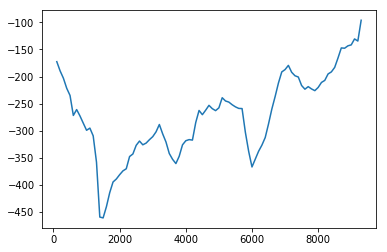

In [19]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key= lambda k: k))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [21]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-12-08 21:18:57,253] Making new env: LunarLander-v2
[2017-12-08 21:18:57,258] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-12-08 21:18:57,262] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.95.3429.video000000.mp4

[2017-12-08 21:19:05,133] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.95.3429.video000001.mp4



Episode finished after 469 timesteps with reward=-130.61901115056432
Episode finished after 1000 timesteps with reward=-161.61570620538876
Episode finished after 552 timesteps with reward=-168.53993711636912
Episode finished after 293 timesteps with reward=-116.30454076281413
Episode finished after 1000 timesteps with reward=-59.8531770772087
Episode finished after 363 timesteps with reward=-128.60676988446977
Episode finished after 156 timesteps with reward=-26.206797119623303


[2017-12-08 21:19:27,160] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.95.3429.video000008.mp4



Episode finished after 440 timesteps with reward=-146.70270525431772
Episode finished after 270 timesteps with reward=-40.71826597041215


[2017-12-08 21:19:32,499] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 429 timesteps with reward=182.8406324859315
average reward: [-130.61901115056432, -161.61570620538876, -168.53993711636912, -116.30454076281413, -59.853177077208699, -128.60676988446977, -26.206797119623303, -146.70270525431772, -40.718265970412148, 182.84063248593151]
